# Tutorial 4 - Public opinion on the climate emergency & why it matters
## Text analysis of COP tweets

Week 2, Day 3: IPCC Socio-economic Basis

By Neuromatch Academy

Content creators: Maximilian Puelma Touzel

Content reviewers: Name Surname, Name Surname

Content editors: Name Surname, Name Surname

Production editors: Name Surname, Name Surname

Our 2023 Sponsors

---
# Tutorial Objectives 

Learn to assess public sentiment about climate change and how it is changing by analyzing changes in word use on social media. An auxillary objective is to learn how to load and analyze large amounts of text.

---
# Setup

Import libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#notebook config
from IPython.display import display, HTML
from IPython.display import Math
import glob
import time
import datetime
import os
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import urllib3
import urllib.request  # the lib that handles the url stuff
!pip install afinn
from afinn import Afinn
import pooch

figure settings

In [2]:
sns.set_style("ticks", {'axes.grid' : False})
display(HTML("<style>.container { width:100% !important; }</style>"))

We will use a Twitter dataset from a publication (Falkenberg et al. *Nature Clim. Chg.* 2022) that collected tweets mentioning the Conference of Parties (COP) conferences at which world governments, NGOs, and business discuss and negotiate progress on climate change.

## Section 0: Data preprocessing

We have done the following preprocessing steps for you (just read along; no need to run anything in this section):

Every Twitter messages (hereon called *tweets*) has an id. Ids of all tweets mentioning `COPx` (x=20-26) used in Falkenberg et al. (2022) were placed by the authors in an osf archive: https://osf.io/nu75j. Download the 7 .csv files (one for each COP) here: https://osf.io/download/pr29x/ 

The program `twarc2` interfaces with the Twitter API. It can be used to hydrate the tweets (i.e. download the full tweet and metadata using the provided tweet id). Similar to github you have to open a Twitter API account and set up twarc on your local machine by giving it your account authentication keys. The command to rehyrdate a set of tweets from their ids is simply `twarc2 hydrate source_file.txt store_file.jsonl`, where each line of `source_file.txt` is a Twitter id and `store_file.jsonl` is where the hydrated tweets are stored.

- First format the downloaded ids and split them into seperate files (*batches*) to make hydration calls to the API more time manageable (hours versus days - this is slow because of an API-imposed limit of 100 tweets/min.). 

In [3]:
# dir_name='Falkenberg2022_data/'
# if not os.path.exists(dir_name):
#     os.mkdir(dir_name)
# batch_size = int(1e5)
# download_pathname=''#~/projects/ClimateMatch/SocioEconDay/Polarization/COP_Twitter_IDs/
# for copid in range(20,27):
#     df_tweetids=pd.read_csv(download_pathname+'tweet_ids_cop'+str(copid)+'.csv')    
#     for batch_id,break_id in enumerate(range(0,len(df_tweetids),batch_size)):
#         file_name="tweetids_COP"+str(copid)+"_b"+str(batch_id)+".txt"
#         df_tweetids.loc[break_id:break_id+batch_size,'id'].to_csv(dir_name+file_name,index=False,header=False)

- Make the hydration calls for COP26 (this took 4 days to download 50GB of data for COP26).

In [4]:
# copid=26
# filename_list = glob.glob('Falkenberg2022_data/'+"tweetids_COP"+str(copid)+"*")
# dir_name='tweet_data/'
# if not os.path.exists(dir_name):
#     os.mkdir(dir_name)
# file_name="tweetids_COP"+str(copid)+"_b"+str(batch_id)+".txt"
# for itt,tweet_id_batch_filename in enumerate(filename_list):
#     strvars=tweet_id_batch_filename.split('/')[1].split('.')[0].split('_')
#     tweet_store_filename = dir_name+'tweets_'+strvars[1]+'_'+strvars[2]+'.json'
#     if not os.path.exists(tweet_store_filename):
#         st=time.time()
#         os.system('twarc2 hydrate '+tweet_id_batch_filename+' '+tweet_store_filename)
#         print(str(itt)+' '+str(strvars[2])+" "+str(time.time()-st))

- Load data

Inspect and pick a chunk size. Note, by default there are 100 tweets per line in the .json files returned by the API. Given we asked for 1e5 tweets/batch, there should be 1e3 lines in these files.

In [5]:
# copid=26
# batch_id = 0
# tweet_store_filename = 'tweet_data/tweets_COP'+str(copid)+'_b'+str(batch_id)+'.json'
# num_lines = sum(1 for line in open(tweet_store_filename))
# num_lines

Now we read in the data, iterating over chunks in each batch and only store the needed data in a dataframe (takes 10-20 minutes to run). Let's look at when the tweets were posted, what language they are in, and the tweet text:

In [6]:
# selected_columns = ['created_at','lang','text']

In [7]:
# st=time.time()
# filename_list = glob.glob('tweet_data/'+"tweets_COP"+str(copid)+"*")
# df=[]
# for tweet_batch_filename in filename_list[:-1]:
#     reader = pd.read_json(tweet_batch_filename, lines=True,chunksize=1)
# #     df.append(pd.DataFrame([item[selected_columns] for sublist in reader.data.values.tolist()[:-1] for item in sublist] )[selected_columns])
#     dfs=[]
#     for chunk in reader:
#         if 'data' in chunk.columns:
#             dfs.append(pd.DataFrame(list(chunk.data.values)[0])[selected_columns])
#     df.append(pd.concat(dfs,ignore_index=True))
# #     df.append(pd.DataFrame(list(reader.data)[0])[selected_columns])
# df=pd.concat(df,ignore_index=True)
# df.created_at=pd.to_datetime(df.created_at)
# print(str(len(df))+' tweets took '+str(time.time()-st))
# df.head()

- finally store the data in the efficiently compressed feather format

In [8]:
# df.to_feather('stored_tweets') 

(run notebook from here)

# Section 1: load and inspect data

Load the preprocessed data

In [9]:
path = pooch.retrieve("https://osf.io/download/8p52x/",known_hash=None)
df=pd.read_feather(path) #takes a couple minutes to download

Let's check the timing of the tweets relative to the COP26 event (duration shaded in blue) to see how the tweets are spread over time.

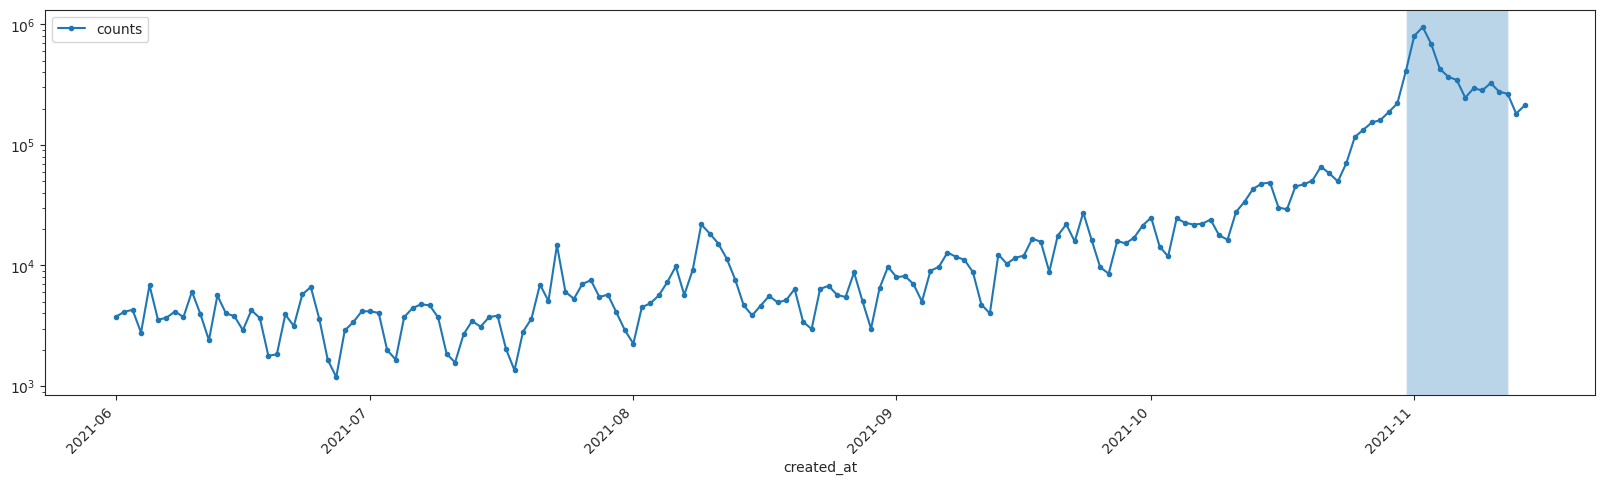

In [10]:
total_tweetCounts=df.created_at.groupby(df.created_at.apply(lambda x: x.date)).count().rename('counts')
total_tweetCounts.reset_index().plot(x='created_at',y='counts',figsize=(20,5),style='.-') 
pl.xticks(rotation=45,ha='right');
pl.gca().set_yscale('log')
COPdates=[datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)] #shade the duration of the COP26 to guide the eye
pl.gca().axvspan(*COPdates, alpha=0.3); #gray region

Who is tweeting about this COP? Look at how many tweets were posted in various languages:

In [11]:
counts=df.lang.value_counts().reset_index()

The stored language name of the tweet is stored as a code name. Pull a language code dictionary from the web and use it to translate the language code to the language name.

In [12]:
target_url='https://gist.githubusercontent.com/carlopires/1262033/raw/c52ef0f7ce4f58108619508308372edd8d0bd518/gistfile1.txt'
exec(urllib.request.urlopen(target_url).read())
lang_code_dict=dict(iso_639_choices)
counts=counts.replace({'index':lang_code_dict})
counts

,index,lang
0,English,6570754
1,Spanish; Castilian,742064
2,French,321012
3,Japanese,229586
4,Portuguese,165717
...,...,...
66,"Pashto, Pushto",23
67,Georgian,22
68,Tibetan,16
69,Sindhi,7


*Exercise*: find your native language code in the dictionary printed below and use it to select the COP tweets that were written in your language!

In [13]:
lang_code_dict

{'ab': 'Abkhaz',
 'aa': 'Afar',
 'af': 'Afrikaans',
 'ak': 'Akan',
 'sq': 'Albanian',
 'am': 'Amharic',
 'ar': 'Arabic',
 'an': 'Aragonese',
 'hy': 'Armenian',
 'as': 'Assamese',
 'av': 'Avaric',
 'ae': 'Avestan',
 'ay': 'Aymara',
 'az': 'Azerbaijani',
 'bm': 'Bambara',
 'ba': 'Bashkir',
 'eu': 'Basque',
 'be': 'Belarusian',
 'bn': 'Bengali',
 'bh': 'Bihari',
 'bi': 'Bislama',
 'bs': 'Bosnian',
 'br': 'Breton',
 'bg': 'Bulgarian',
 'my': 'Burmese',
 'ca': 'Catalan; Valencian',
 'ch': 'Chamorro',
 'ce': 'Chechen',
 'ny': 'Chichewa; Chewa; Nyanja',
 'zh': 'Chinese',
 'cv': 'Chuvash',
 'kw': 'Cornish',
 'co': 'Corsican',
 'cr': 'Cree',
 'hr': 'Croatian',
 'cs': 'Czech',
 'da': 'Danish',
 'dv': 'Divehi; Maldivian;',
 'nl': 'Dutch',
 'dz': 'Dzongkha',
 'en': 'English',
 'eo': 'Esperanto',
 'et': 'Estonian',
 'ee': 'Ewe',
 'fo': 'Faroese',
 'fj': 'Fijian',
 'fi': 'Finnish',
 'fr': 'French',
 'ff': 'Fula',
 'gl': 'Galician',
 'ka': 'Georgian',
 'de': 'German',
 'el': 'Greek, Modern',
 'gn': '

Select tweets of a given language

In [14]:
language_code = 'en'
df=df.loc[df.lang==language_code,:].reset_index(drop=True)
pd.options.display.max_rows=100 #see up to 100 entries
pd.options.display.max_colwidth=250 #widen how much text is presented of each tweet
df.sample(100)

,created_at,lang,text
1847034,2021-08-06 21:58:15+00:00,en,"No surprise then, that @COP26 #cop26 Pres, @AlokSharma_RDG, deeply regrets more lives haven’t been lost to #covid19 🦠 #coronavirus. https://t.co/XGrL395ODd https://t.co/R1CGW29B6e"
4961992,2021-11-06 17:16:07+00:00,en,RT @alianzabosques: “There is no future without nature and community based solutions” \nOur líder @svallegustavo during the climate march ea…
3892962,2021-09-11 07:56:06+00:00,en,COP26 will be yet another failure by Governments
468348,2021-10-11 13:01:13+00:00,en,"RT @CarbonBubble: .@NicolaSturgeon: ""The world must move from promises to action, &amp; mobilise the ambition, finance, resources &amp; joint worki…"
3150767,2021-11-02 10:42:12+00:00,en,"RT @pb4p: Join us for a public meeting on COP26 &amp; the case for eco-socialism, with @bridsmithTD, @fiona_ferg, @BabaAye and Martin Empson a…"
3044190,2021-11-02 07:35:30+00:00,en,"RT @narendramodi: The @COP26 Summit offers a wonderful opportunity to interact with various world leaders. \n\nIn a short while, I will be de…"
6438828,2021-11-13 02:08:50+00:00,en,"RT @nytimes: Twenty-three wealthy countries are responsible for 50% of historical carbon dioxide emissions. At the UN climate summit, one o…"
1441427,2021-10-28 02:06:24+00:00,en,RT @UKinKorea: It’s been a real pleasure to work with @BLACKPINK on #ClimateActionInYourArea\n\nNext stop… Glasgow @COP26\n\n#COP26 #TogetherFo…
6265738,2021-11-12 08:40:05+00:00,en,"What's been happening at #COP26? Some of the key moments from the 2-week climate conference... \n\n2. Greta Thunberg joined protesters in Glasgow, leading anger at our world leaders for not yet doing enough. https://t.co/KEK6garGKN"
4382402,2021-11-04 17:01:00+00:00,en,RT @SadhguruJV: Only with collective global effort and wholehearted commitment to ecologically sustainable solutions can we bring about a s…


## Section 2: Word set prevelance

[Falkenberg et al.](https://www.nature.com/articles/s41558-022-01533-z) investigated the hypothesis that *public sentiment* around the COP conferences has increasingly framed them as hypocritical ("political hypocrisy as a topic of cross-ideological appeal"). The authors operationalized hypocrisy language as any tweet containing any of the following words:

In [15]:
selected_words = ['hypocrisy', 'hypocrite', 'hypocritical', 'greenwash','green wash', 'blah'] #the last 3 words don't add much. Greta Thurnberg's 'blah, blah blah' speech on Sept. 28th 2021.

*Question*: How might this matching procedure be limited in its ability to capture this sentiment?

*Answer*:

The authors then searched for these words within a distinct dataset across all COP conferences (this dataset was not made openly accessible; result: the figure using that data is here: https://www.nature.com/articles/s41558-022-01527-x/figures/7). They found that hypocrisy has been mentioned more in recent COP conferences.


Here, we will instead focus on their acessible COP26 dataset and assess the nature of comments about specific topics, like political hypocrisy.

In [16]:
selectwords_detector = re.compile(r'\b(?:{0})\b'.format('|'.join(selected_words))) #to make a word detector for a wordlist faster to run, compile it!
df['select_talk']=df.text.apply(lambda x: selectwords_detector.search(x,re.IGNORECASE)) # look through whole dataset, flagging tweets with select_talk (computes in under a minute)

Let's pull these tweets out and look at thier occurence statistics relative to those of the whole dataset computed above

In [17]:
selected_tweets=df.loc[~df.select_talk.isnull(),:]
selected_tweet_counts=selected_tweets.created_at.groupby(selected_tweets.created_at.apply(lambda x: x.date)).count().rename('counts')
selected_tweet_fraction=selected_tweet_counts/total_tweetCounts

Text(0, 0.5, 'fraction talking about hypocrisy')

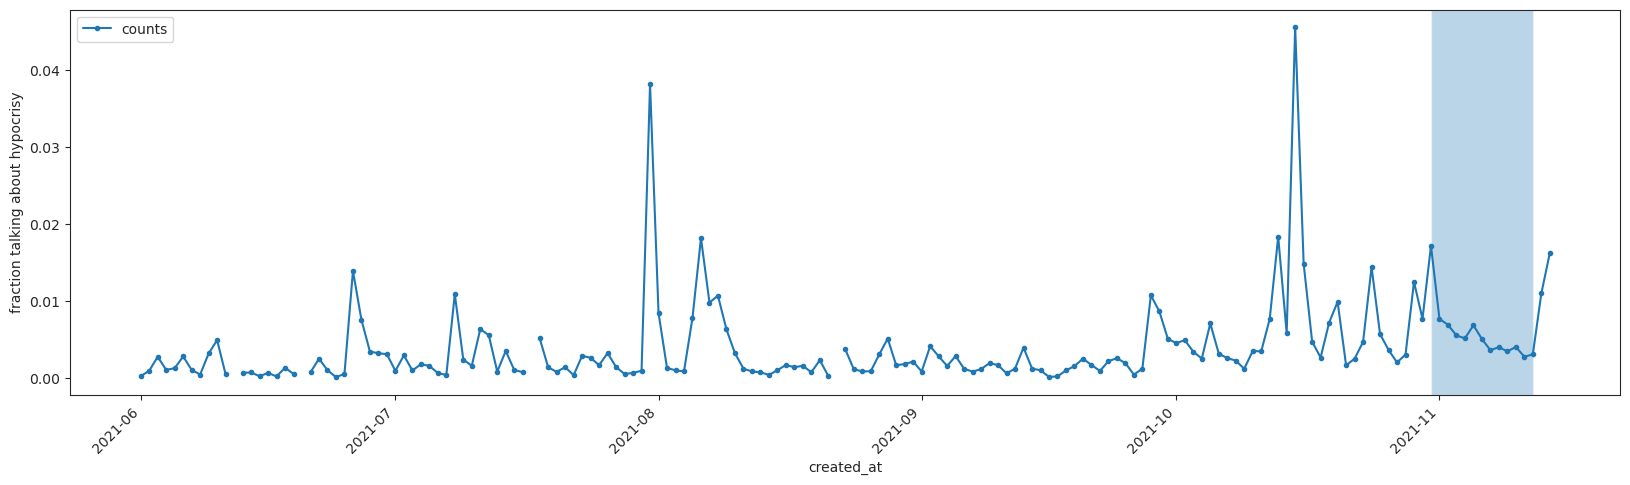

In [18]:
selected_tweet_fraction.reset_index().plot(x='created_at',y='counts',figsize=(20,5),style=['.-']) #this doesn't 
pl.xticks(rotation=45,ha='right');
pl.gca().axvspan(*COPdates, alpha=0.3) #gray region
pl.gca().set_ylabel('fraction talking about hypocrisy')

Note these are normalized so larger fractions closer to the COP26 dates correspond to significantly more absolute number of tweets. 

Let's look at what these tweets say. Take 100 randomly sampled.

In [19]:
selected_tweets.text.sample(50).values

array(['RT @thecoastguy: If Cop26 doesn’t alert you to the utter, utter, utter hypocrisy of the self-serving do-as-I-say-and-not-as-I-do brigade, t…',
       'RT @Nigel_Farage: Every world leader or dignitary that arrives to @COP26 by private jet is an eco-hypocrite. Fact.',
       'RT @Scottludlam: a quarter of the nationals MPs who are deciding whether morrison gets some kind of greenwash excuse to show up at COP26 ho…',
       'RT @HoodedMan: @jasonhickel @Puddledumpling Twenty-six years of vast hypocrisy and deception and lies and general inaction and ongoing subs…',
       "RT @GBNEWS: Mark Dolan on COP26: 'After two weeks of hot air and with hypocritical leaders and billionaires producing a carbon footprint bi…",
       'RT @darrenmark69: If the brainwashed covid sheep are still watching MSM and seeing the hypocrisy actually playing out over #COP26, the priv…',
       'I understand the anger over the alleged hypocrisy of COP26 - the motorcades, the flights, the bacon baps etc, bu

*Exercise*: Pick another topic, propose a list of topic words, and run the same analysis. (Example topic: "renewable technology")

In [2]:
#copy code here 

## Section 3: Sentiment analysis

The hypocrisy displayed above seems charged against international organizations central to globalization (e.g. G7). Let's assess that hypothesis by analyzing the sentiment of the subset of these hypocrisy tweets that mention these institutions. 

(part of the computation flow in what follows was taken from Caren Neal's tutorial: https://nealcaren.org/lessons/wordlists/)

We'll match words in tweets to sentiment scores using a dictionary method. The particular dictionary we will use is compiled in the AFINN package and reflects a scoring between -5 and 5 in which words were rated for valence. Let's initialize it for the language we've chosen.

In [20]:
afinn = Afinn(language=language_code)

Load the dictionary

In [21]:
afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')
afinn_wl_df = pd.read_csv(afinn_wl_url,
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value']) #new column names
seed = 808 # seed for sample so results are stable
afinn_wl_df.sample(10, random_state = seed)

,term,value
1852,regret,-2
1285,indifferent,-2
681,disappoints,-2
770,doubts,-1
1644,outmaneuvered,-2
55,admit,-1
1133,haha,3
1160,haunt,-1
2435,wishing,1
21,abused,-3


let's look at the distribution of scores over all words in the dictionary

Text(0, 0.5, 'dictionary counts')

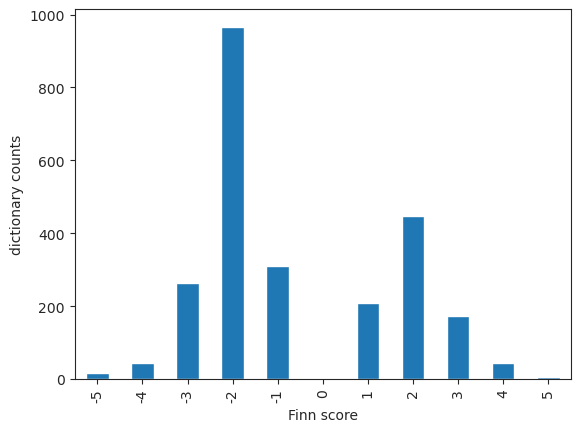

In [22]:
afinn_wl_df.value.value_counts().sort_index().plot.bar()
pl.gca().set_xlabel('Finn score')
pl.gca().set_ylabel('dictionary counts')

These scores were assigned to words based on labeled tweets ([validation paper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf)).  

Before focussing on sentiments about institutions within the hypocrisy tweets, let's look at the hypocrisy tweets in comparison to non-hypocrisy tweets. This will take some more intensive computation, so let's only perform it on a 1% subsample of the dataset

In [32]:
smalldf=df.sample(frac=0.01)

In [33]:
smalldf['afinn_score'] = smalldf.text.apply(afinn.score) #intensive computation! We have reduced the data set to frac=0.01 it's size so it takes ~1 min. (the full dataset takes 1hrs 50 min.)

In [34]:
smalldf['afinn_score'].describe()

count    65708.000000
mean         0.405871
std          2.775230
min        -19.000000
25%         -1.000000
50%          0.000000
75%          2.000000
max         19.000000
Name: afinn_score, dtype: float64

The score is a sum over all dictionary words in the tweet so is larger for longer tweets. 

A rough approach to making scores comparable across tweets of different length is convert to a per-word score by normalizing each tweet's score by its word count (note this is not a per-dictionary word score and so this rough approach introduces a bias dependent on how much of each tweet is formed by dictionary words). Let's call this normalized score *afinn_adjusted*.

In [35]:
def word_count(text_string):
    '''Calculate the number of words in a string'''
    return len(text_string.split())
smalldf['word_count']=smalldf.text.apply(word_count)
smalldf['afinn_adjusted'] = smalldf['afinn_score'] / smalldf['word_count'] #note this isn't a percentage

In [36]:
smalldf['afinn_adjusted'].describe()

count    65708.000000
mean         0.017620
std          0.128603
min         -1.600000
25%         -0.040000
50%          0.000000
75%          0.086957
max          1.400000
Name: afinn_adjusted, dtype: float64

Now let's look at the sentiment of tweets with hypocrisy words versus those without those words. We'll first plot for some other possibly negative words for reference.

In [37]:
for sel_words in [['Fossil'],['G7'],['Boris'],['Davos'],selected_words]:
    sel_name = sel_words[0] if len(sel_words)==1 else 'select_talk'
    selectwords_detector = re.compile(r'\b(?:{0})\b'.format('|'.join(sel_words))) #compile for speed!
    smalldf[sel_name] = smalldf.text.apply(lambda x: selectwords_detector.search(x,re.IGNORECASE) is not None) #flag if tweet has word(s)

make cumulative distribtion plots of score distributions

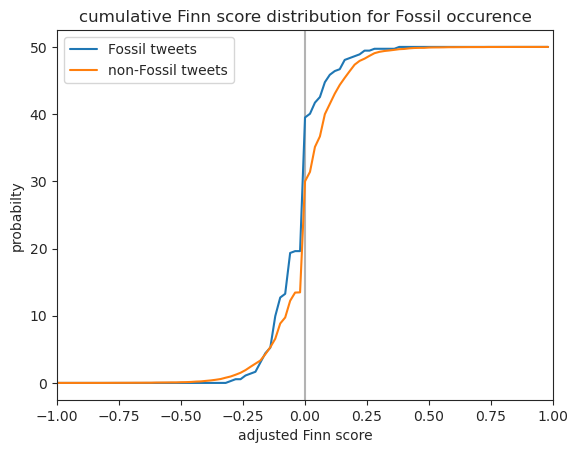

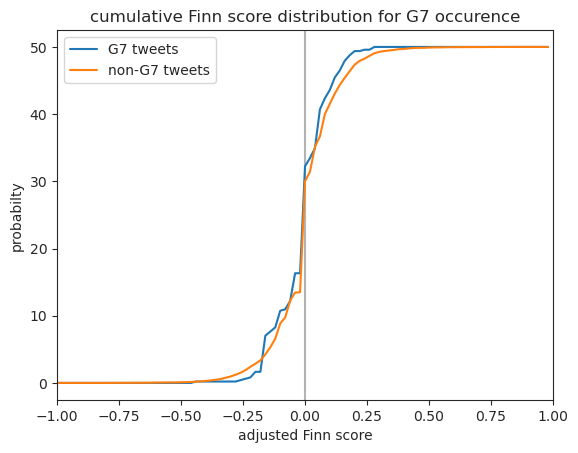

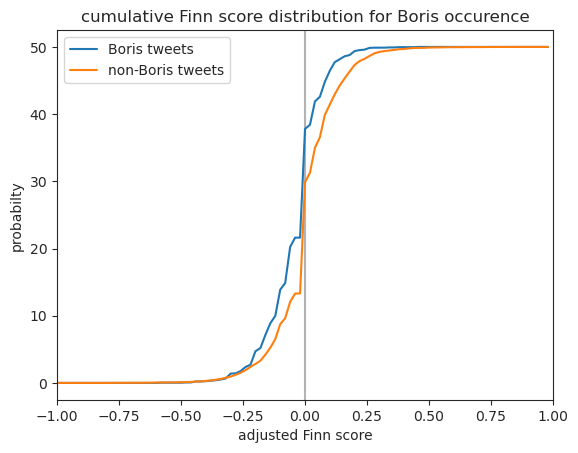

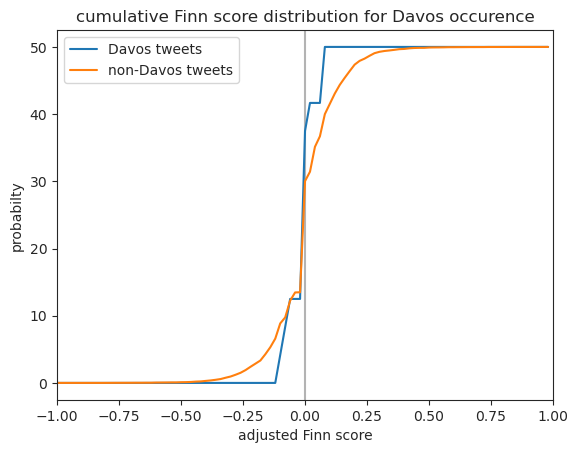

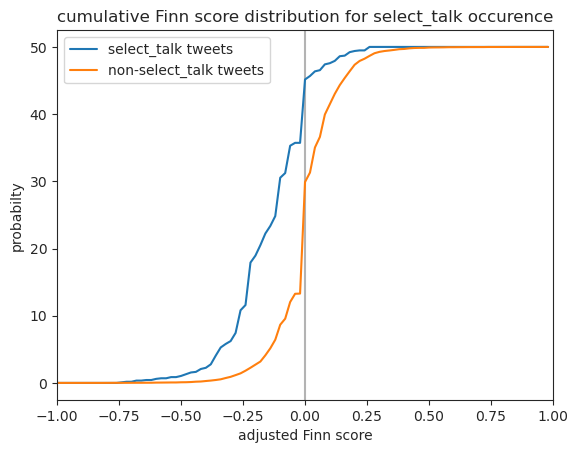

In [39]:
for sel_words in [['Fossil'],['G7'],['Boris'],['Davos'],selected_words]:
    sel_name =sel_words[0] if len(sel_words)==1 else 'select_talk'
    fig,ax=pl.subplots()
    pl.gca().set_xlim(-1,1)
    pl.gca().set_xlabel('adjusted Finn score')
    pl.gca().set_ylabel('probabilty')
    counts,bins=np.histogram(smalldf.loc[smalldf[sel_name],'afinn_adjusted'],bins=np.linspace(-1,1,101),density=True)
    pl.plot(bins[:-1],np.cumsum(counts),color='C0',label=sel_name+' tweets')
    counts,bins=np.histogram(smalldf.loc[~smalldf[sel_name],'afinn_adjusted'],bins=np.linspace(-1,1,101),density=True)
    pl.plot(bins[:-1],np.cumsum(counts),color='C1',label='non-'+sel_name+' tweets')
    pl.gca().axvline(0,color=[0.7]*3,zorder=1)
    pl.legend()
    pl.title('cumulative Finn score distribution for '+sel_name+ ' occurence')

Observe that tweets containing the selected *hypocrisy*-associated words set are scored much more negative than all of these. So what is the content of these selected tweets?

## Section 4: word clouds

To analyze word usage, let's first vectorize the text data. Vectorization here means giving each word in the vocabulary an index and transforming each word sequence in each to its vector representation whose sequence of elements are the sequence of the corresponding word indices (e.g. the response `['I','love','icecream']` maps to something like `[34823,5937,79345]`). 

We'll use and compare two methods: term-frequency (tf) and term-frequency inverse document frequency (tfidf). Unhide the next cell to see thier definition.

Let's write down what they compute by denoting the index, $d$, over the $D$ documents and the index, $w$, over the $W$ words in the vocabulary (the list of all the words found in all the tweets, which we'll call documents): 
- term frequency, $\mathrm{tf}(w,d)$. The frequency of a word $w$ in a document $d$ is $$\mathrm{tf}(w,d):=\frac{n(w,d)}{n(d)},$$ where $n(w,d)$ is the number of times term $w$ is in document $d$ and $n(d)=\sum_{w=1}^W n(w,d)$ is the total number of words in document $d$. The term frequency over all the documents is then, $$\mathrm{tf}(w):=\frac{\sum_{d=1}^D n(d)\mathrm{tf}(w,d)}{N},$$ where the denominator $N=\sum_{d=1}^D n(d)$ is just the total word count across all documents.
- term frequency-inverse document frequency, $\mathrm{Tfidf}(w,d):=\mathrm{tf}(w,d)\mathrm{idf}(w)$. Here, $$\mathrm{idf}(w)=\frac{\log(D+1)}{\log(n(w)+1)+1},$$ where $n(w)$ is the number of documents in which term $t$ appears, i.e. $n(w,d)>0$. Idf is like an inverse document frequency. The `sklearn` package then uses $$\mathrm{Tfidf}(w)=\frac{1}{D}\sum_{d=1}^D \frac{\mathrm{Tfidf}(w,d)}{||\mathrm{Tfidf}(\cdot,d)||},$$ where $||\vec{x}||=\sqrt{\sum_{i=1}^Nx^2_i}$ is the Euclidean norm.

$\mathrm{Tfidf}$ aims to add more discriminability to frequency as a word relevance metric by downweighting words that appear in many documents since these common words are less discriminative.

Let's run both these methods and store the vectorized data in a dictionary

In [40]:
vectypes=['counts','Tfidf']
def vectorize(doc_data,ngram_range=(1,1),remove_words=[],min_doc_freq=1):

    vectorized_data_dict={}
    for vectorizer_type in vectypes:
        if vectorizer_type=='counts':
            vectorizer = CountVectorizer(stop_words=remove_words,min_df=min_doc_freq,ngram_range=ngram_range) 
        elif vectorizer_type=='Tfidf':
            vectorizer = TfidfVectorizer(stop_words=remove_words,min_df=min_doc_freq,ngram_range=ngram_range) 

        vectorized_doc_list = vectorizer.fit_transform(data).todense().tolist()
        feature_names = vectorizer.get_feature_names_out() # or  get_feature_names() depending on scikit learn version
        print('vocabulary size:'+str(len(feature_names)))
        wdf = pd.DataFrame(vectorized_doc_list, columns=feature_names)
        vectorized_data_dict[vectorizer_type]=wdf
    return vectorized_data_dict,feature_names

def plot_wordcloud_and_freqdist(wdf,title_str,feature_names):
    '''
    Plots a word cloud
    '''
    pixel_size=600
    x,y =np.ogrid[:pixel_size,:pixel_size]
    mask = (x -pixel_size/2)**2+(y-pixel_size/2)**2>(pixel_size/2-20)**2
    mask=255*mask.astype(int)
    wc=WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", mask=mask, max_words=50)#,relative_scaling=1)
    wordfreqs=wdf.T.sum(axis=1)
    num_show=50
    sorted_ids=np.argsort(wordfreqs)[::-1]

    fig,ax=pl.subplots(figsize=(10,5))
    ax.bar(x=range(num_show),height=wordfreqs[sorted_ids][:num_show])
    ax.set_xticks(range(num_show))
    ax.set_xticklabels(feature_names[sorted_ids][:num_show],rotation=45,fontsize=8,ha='right');
    ax.set_ylabel('total frequency')
    ax.set_title(title_str+' vectorizer')
    ax.set_ylim(0,10*wordfreqs[sorted_ids][int(num_show/2)])
    
    ax_wc = inset_axes(ax,width='90%',height='90%')
    wc.generate_from_frequencies(wordfreqs)
    ax_wc.imshow(wc,interpolation='bilinear')
    ax_wc.axis('off')
    
nltk.download('stopwords') #downloads basic stop words, i.e. words with little semantic value  (e.g. "the"), to be used as words to be removed
remove_words = stopwords.words("english") 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mptouzel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Okay so let's vectorize and look at the wordclouds for single word statistics. Let's explicitly exclude some words and implicity exclude ones that appear in fewer than some threshold number of documents

In [41]:
data=selected_tweets['text'].sample(frac=0.1).values #reduce size since the vectorization computation transforms the corpus into an array of large size (vocabulary size x number of tweets)
#let's add some more words that we don't want to track (you can generate this kind of list iteratively by looking at the results and adding to this list):
remove_words += ['cop26','http','https','30','000','je','rt','climate','limacop20','un_climatetalks','climatechange','via','ht','talks','unfccc','peru','peruvian','lima','co']
print(str(len(data))+" tweets")
min_doc_freq=5/len(data)

5747 tweets


vocabulary size:1725
vocabulary size:1725


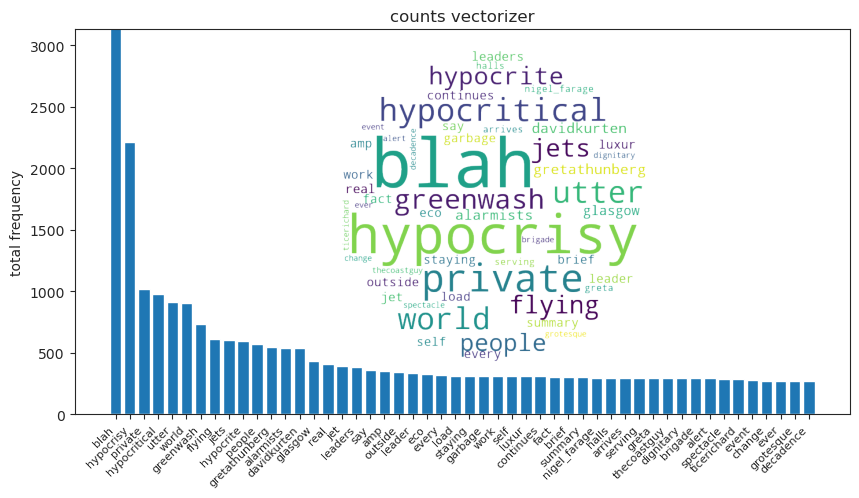

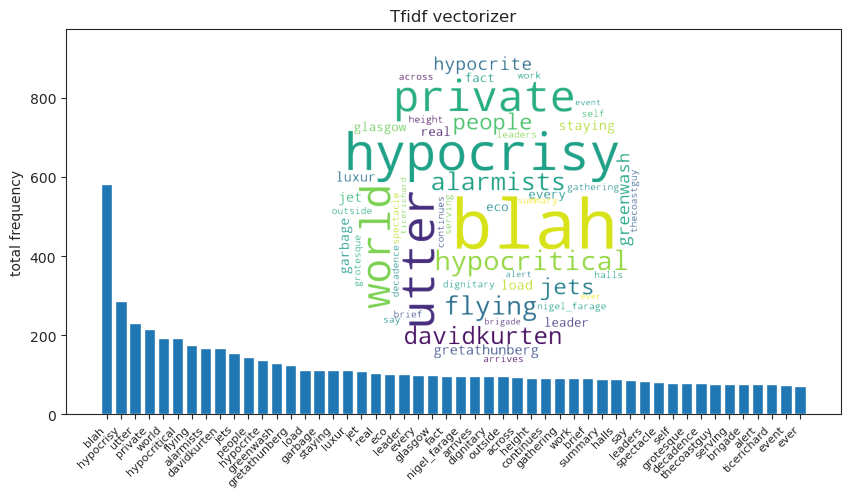

In [42]:
ngram_range=(1,1) #start and end number of words
vectorized_data_dict,feature_names=vectorize(selected_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

Note in the histograms how the TFidf vectorizer has scaled down the hypocrisy words such that they are less outlyingly prevalent relative to the count vectorizer. 

There are some words here  (e.g. `private` and `jet`) that look like they likely would appear in pairs. Let's tell the vectorizer to also look for high frequency *pairs* of words.

vocabulary size:3395
vocabulary size:3395


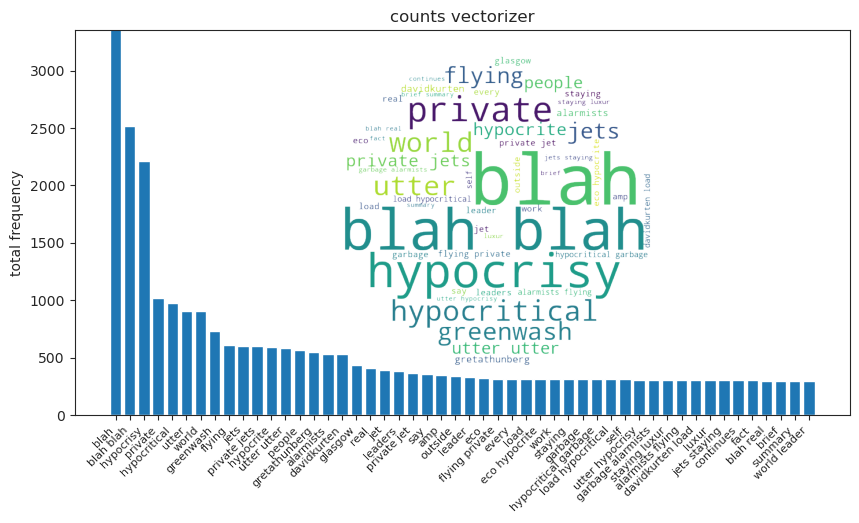

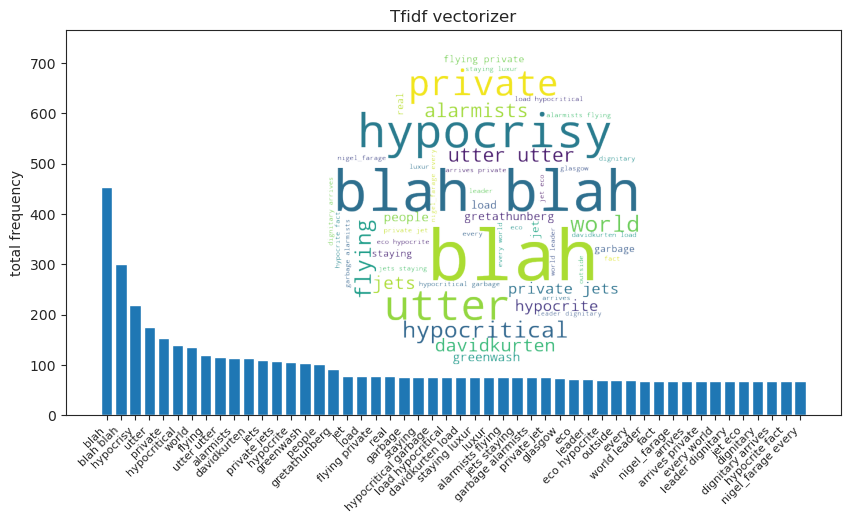

In [43]:
ngram_range= (1,2)#start and end number of words
vectorized_data_dict,feature_names=vectorize(selected_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

The hypocrisy words take up so much frequency it is hard to see what the remaining words are. To clear this list a bit more, let's also remove the hypocrisy words altogether.

In [44]:
remove_words += selected_words

/home/mptouzel/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['green', 'wash'] not in stop_words.
  warnings.warn(


vocabulary size:3188


/home/mptouzel/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['green', 'wash'] not in stop_words.
  warnings.warn(


vocabulary size:3188


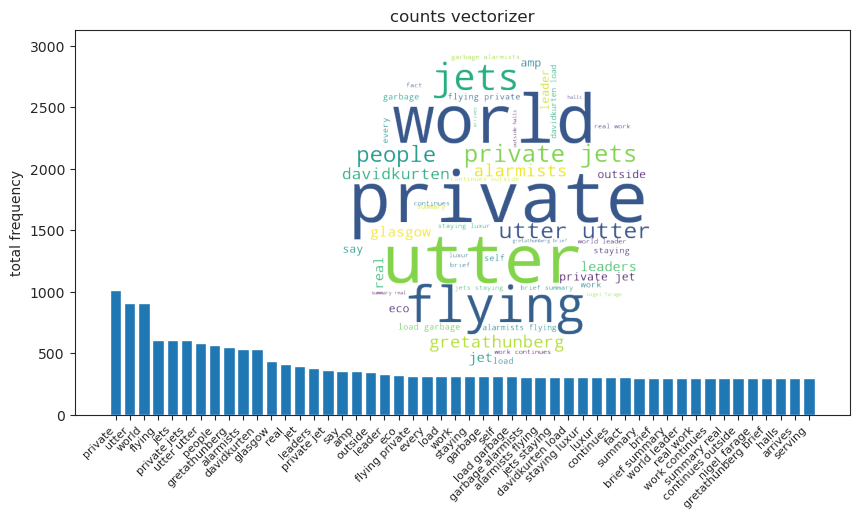

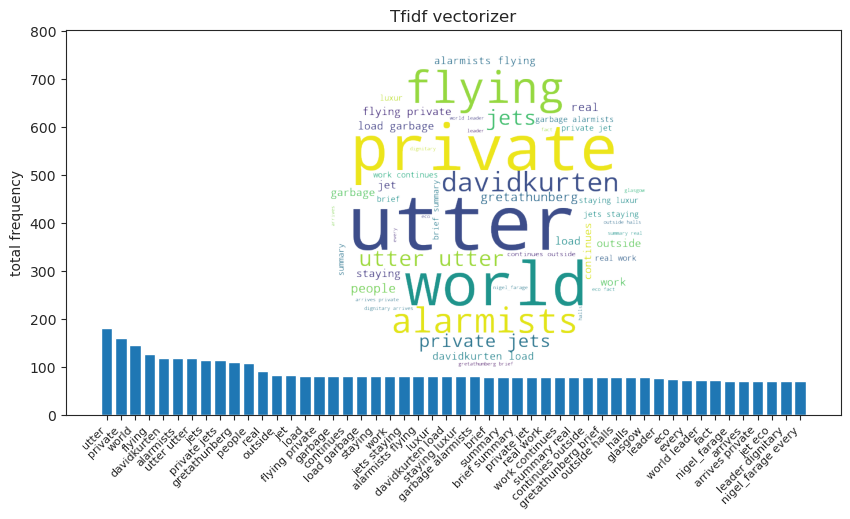

In [45]:
ngram_range= (1,2)#start and end number of words
vectorized_data_dict,feature_names=vectorize(selected_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

Observe terms that we might have expected are associated to hypocrisy, e.g. "flying". Even when allowing for pairs, the semantics are hard to extract from this analysis that ignores the correlations in usage among multiple words. 

To futher assess statistics, one approach is use a generative model with latent structure.

Topic models (the [structural topic model](https://www.structuraltopicmodel.com/) in particular) are a nice modelling framework to start analyzing those correlations.

For a modern introduction to text analysis in the social sciences, I recommend the textbook:

    Text as Data: A New Framework for Machine Learning and the Social Sciences (2022) by Justin Grimmer, Margaret E. Roberts, and Brandon M. Stewart